# Various efforts to explore and validate party embeddings

In [4]:
import pickle
import pandas as pd
import numpy as np
import umap
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from politician2vec import Politician2Vec
from politician2vec.utils import *
import matplotlib.pyplot as plt
import seaborn as sns
iris = sns.load_dataset('iris')
plt.style.use('seaborn-whitegrid')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mathiasbruun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mathiasbruun/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/mathiasbruun/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mathiasbruun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/mathiasbruun/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [5]:
test_data_path = 'data/clean/combined/subset_party_imputed_v2.p'

In [6]:
with open(test_data_path, 'rb') as p:
    test_data = pickle.load(p)

test_data.shape

(349594, 7)

In [8]:
tw_data = test_data.loc[
    test_data['source'] == 'twitter'
]

In [10]:
tw_data['full_name'].drop_duplicates()


778          Alex Vanopslagh
4781            Alternativet
9312      Alternativets Unge
10586        Anders Kronborg
13315      Andreas Steenberg
                 ...        
339010           Ulla Tørnæs
339620               Venstre
344990       Venstres Ungdom
345179        Yildiz Akdogan
348700          Zenia Stampe
Name: full_name, Length: 154, dtype: object

In [6]:
grouped_docs = tw_data.groupby(['full_name', 'party'])['doc'].apply('. '.join).reset_index()

In [7]:
grouped_docs

,full_name,party,doc
0,Alex Vanopslagh,LA,Det offentlige forbrug er steget med 9 mia. kr...
1,Alternativet,ALT,RT @TFKortholm: Vi er klar til valgkampen 💚🖖 S...
2,Alternativets Unge,ALT,Vores super seje @OlumekoC er på den internati...
3,Anders Kronborg,S,RT @DSU_1920: Statsministeren underskriver DSU...
4,Andreas Steenberg,RV,"Hvad er egentlig @SorenPape, @KonservativeDK, ..."
...,...,...,...
161,Ulla Tørnæs,V,RT @JakobEllemann: Danskerne drømmer om at bo ...
162,Venstre,V,RT @AndreasBachM: 75.135 ‼️ gange tak til alle...
163,Venstres Ungdom,V,En borgerlig statsminister forudsætter et borg...
164,Yildiz Akdogan,S,"@JackPGB Ja, man får det dårligt 😔. Det her gø..."


In [8]:
model_path = 'embedding_models/politician2vec_test_deeplearn_v3.txt'

In [9]:
pol2vec_model, doc2vec_model = load_politician2vec_from_txt(model_path)

Loading Politician2Vec model...
Retrieving document embedding...
All done!


In [192]:
# TODO: This should probably be implemented as a method of the Politician2Vec class
#
# NOTE: As of 2022-11-26, it has been decided to keep party 'inference' parallel to the original top2vec implementation.
#       This funtionality may prove useful in outlier detection, but--importantly--it requires the ex ante known party affilaitions
#       to be mapped to model output ex post instead of relying on inferred parties. Specifically, the 'estimated' party affiliations
#       may vary from ground truth labels in the case of semantically outlying politicians with only few data points.

def inspect_topic(politician2vec_model, topic_idx, n_docs=None, query_substr=None):
    '''
    Print top words and top docs for a given
    topic.
    -------
    manual_num (int):  automatically assigned topic number (i.e. 0-indexed).
    
    n_docs (int, optional): n top documents to print for a given topic.
        Default is to print all docs within a given topic.
    
    query_substr (str, optional): if specified, only documents containing
        this substring will be printed. Cannot be specified with n_docs,
        as this would return only results within a subset of topic docs.
    '''

    num_topics = politician2vec_model.get_num_topics()
    topic_words, word_scores, topic_nums = politician2vec_model.get_topics(num_topics)

    # Get topic sizes so we know max n docs
    topic_sizes, topic_nums = politician2vec_model.get_topic_sizes()
    docs_to_return = topic_sizes[topic_idx]

    # Override n docs to return, if specified
    if n_docs:
        docs_to_return = n_docs

    # Get docs for input topic id
    documents, document_scores, document_ids = politician2vec_model.search_documents_by_topic(
        topic_num=topic_idx,
        num_docs=docs_to_return
        )

    # Limit output to docs containign certain substring, if specified
    if query_substr and n_docs:
        raise Exception('Please do NOT specify n_docs with substring query!\nOtherwise the search is only carried out for a subset of topic docs.')
    
    # Throw exception if substring query attempted on subset of docs!
    elif query_substr:
        documents = [doc for doc in documents if query_substr in doc.lower()]

    # Print output
    print('--- TOP 50 WORDS ---\n', topic_words[topic_idx], '\n')

    print(f'--- TOP {docs_to_return} DOCS. SUBSTRING QUERY: {query_substr} (n = {len(documents)}) ---\n', documents)

In [203]:
def find_topic_words_and_scores(pol2vec_model):
    topic_words = []
    topic_word_scores = []

    res = np.inner(pol2vec_model.topic_vectors, pol2vec_model.word_vectors)
    top_words = np.flip(np.argsort(res, axis=1), axis=1)
    top_scores = np.flip(np.sort(res, axis=1), axis=1)

    for words, scores in zip(top_words, top_scores):
        topic_words.append([pol2vec_model.vocab[i] for i in words[0:100]])
        topic_word_scores.append(scores[0:100])

    topic_words = np.array(topic_words)
    topic_word_scores = np.array(topic_word_scores)

    return topic_words, topic_word_scores

In [224]:
tw_data.head().values

array([[2240,
        'Det offentlige forbrug er steget med 9 mia. kr. mere end det demografiske træk berettiger i denne valgperiode. Hvis regeringen havde pålagt sig selv det samfundsbidrag, at pengene i stedet skulle gå til større beskæftigelsesfradrag, ville en alm familie have 10.000 ekstra årligt.',
        'twitter', datetime.date(2022, 9, 19), 'Alex Vanopslagh',
        'politician', 'LA'],
       [2241,
        'RT @olebirkolesen: Mangel på arbejdskraft? Kald på LA! https://t.co/DoS21exHlU',
        'twitter', datetime.date(2022, 9, 19), 'Alex Vanopslagh',
        'politician', 'LA'],
       [2242,
        '@RStoklund @engelschmidt @larsloekke @PernilleVermund @SorenPape Appellere til folks indre svinehund*',
        'twitter', datetime.date(2022, 9, 18), 'Alex Vanopslagh',
        'politician', 'LA'],
       [2243,
        '@RStoklund @engelschmidt @larsloekke @PernilleVermund @SorenPape Det som Løkke fremlægger i JP er noget helt andet end det FM har regnet på. Så du har nok 

In [225]:
# Capture groups in preproc regex need some debugging (as we well knew...)
preproc_docs(
    'RT @olebirkolesen: Mangel på arbejdskraft? Kald på LA!'
)

['olebirkolesen', 'mangel', 'arbejdskraft', 'kald', 'la']

#### VALIDATION STEPS
- Check what happens to twitter embedding if we fix preproc script so it cannot rely on rts/mentions to learn positions
- Attempt to recreate Epinion scale using PCA/UMAP
- Plot salient words in relation to party positions (perhaps not actual coordinates in this POC, otherwise we should probably UMAP parties alone and then project words onto this subspace)
- Only *then* we attempt populism...

In [230]:
find_topic_words_and_scores(pol2vec_model)[0][8]

array(['liberalalliance', 'olebirkolesen', 'liberalalliance liberal',
       'liberal', 'la', 'liberal politik', 'liberalalliance la',
       'liberal alliances', 'forslag liberal', 'alexvanopslagh',
       'rt liberalalliance', 'vel', 'borgerlig liberal', 'sociologenhd',
       'fordi', 'heller', 'venstrefløjen', 'liberalalliance mette',
       'pointe', 'forstår', 'københavns borgerrepræsentation', 'las',
       'liberal alliance', 'brianweichardt', 'københavns byret',
       'ægte liberal', 'pointen', 'konservative liberal', 'lavere',
       'pelle', 'folk', 'tror', 'korrekt', 'dit', 'ligesom', 'mener',
       'synes', 'mindre', 'forskellen', 'samme', 'rt ekstrabladet',
       'ejer', 'las folketingsgruppe', 'lavere selskabsskat', 'liberalt',
       'liberale', 'nej', 'stedet føre', 'pct', 'la rt', 'mene',
       'føre højere', 'hvilket', 'skat', 'rt brianweichardt', 'parti',
       'føre politik', 'ved', 'helst', 'las økonomiske', 'la la',
       'privat ejendom', 'bestemmer', 'bar

In [10]:
# FOR PLOTTING, I WILL PROBABLY HAVE TO UMAP POLITICIANS/PARTIES FIRST, AND THEN PROJECT WORDS ONTO THIS SPACE

In [11]:
colormap = {
    'S': '#C8042C',
    'V': '#1A4289',
    'DF': '#265BA4',
    'EL': '#BF2850',
    'SF': '#B42D27',
    'KF': '#24573E',
    'RV': '#D82E8A',
    'LA': '#E7B657',
    'ALT': '#75FB4C',
    'NB': '#1E4B57',
    'KD': '#566197',
    'FG': '#E4F04E',
    'DD': '#3470BC',
    'M': '#7A308B',
    'SIU': 'lightgrey',
    'UFG': 'lightgrey'
}

In [12]:
docvecs = pol2vec_model.document_vectors

In [138]:
pca = PCA(n_components=2)

In [139]:
mapper = pca.fit_transform(
    docvecs
)

grouped_docs['x'] = mapper.T[0]
grouped_docs['y'] = mapper.T[1]

In [183]:
mapper = umap.UMAP(
    n_neighbors=15,
    metric='cosine',
    n_components=3
    ).fit(
        docvecs
    )

grouped_docs['x'] = mapper.embedding_.T[0]
grouped_docs['y'] = mapper.embedding_.T[1]
grouped_docs['y'] = mapper.embedding_.T[2]

In [184]:
parties_to_remove = [] #'M', 'KD', 'DD', 'FG', 'UFG'

plot_docs = grouped_docs.loc[~grouped_docs['party'].isin(parties_to_remove)]

In [185]:
#order = ['ALT', 'RV', 'EL', 'SF', 'DF', 'NB', 'S', 'LA', 'V', 'KF']
#plot_docs['party'] = plot_docs['party'].astype("category")
#plot_docs['party'] = plot_docs['party'].cat.set_categories(order)
#plot_docs = plot_docs.sort_values(["party"])

/Users/mathiasbruun/me/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/mathiasbruun/me/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


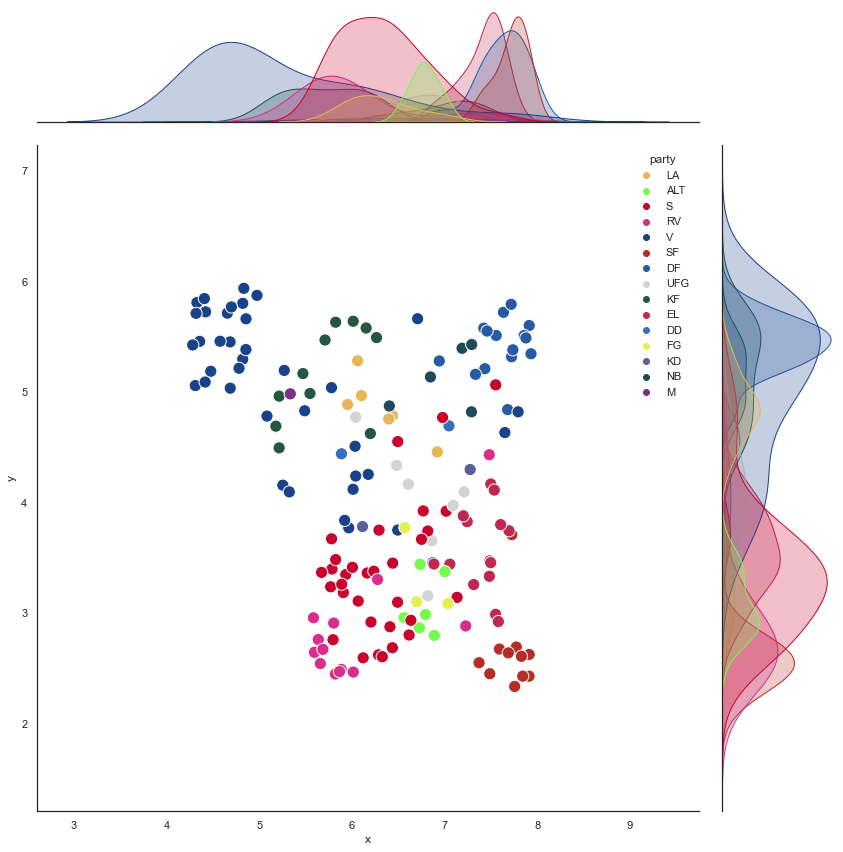

In [191]:
sns.jointplot(
    data = plot_docs,
    x = 'x',
    y = 'y',
    hue = 'party',
    palette = colormap,
    alpha = 1,
    height = 12,
    s=150,
    # ylim = (2, 6.5),
    # xlim = (2, 6.5),
)

# THIS KINDA SORTA LOOKS LIKE THE EPINION SCALE.

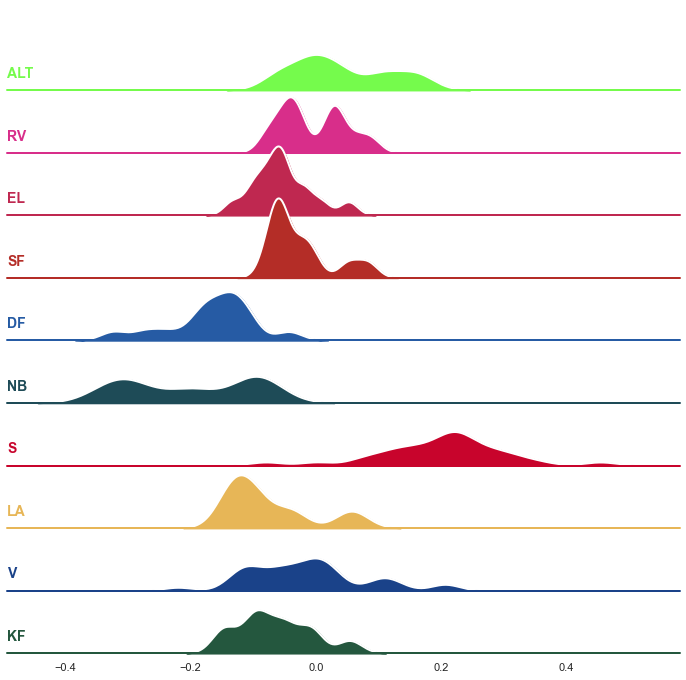

In [105]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, start=1, rot=-.25, light=.7)
g = sns.FacetGrid(plot_docs, row="party", hue="party", aspect=10, height=1, palette=colormap)

# Draw the densities in a few steps
g.map(sns.kdeplot, "z",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "z", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
# g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
g.map(plt.axhline, y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", size = 14, color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "z")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], xlabel="", ylabel="")
g.despine(bottom=True, left=True)
plt.show()

/Users/mathiasbruun/me/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:1184: UserWarning: The following kwargs were not used by contour: 'warn_singular'
  **contour_kws,


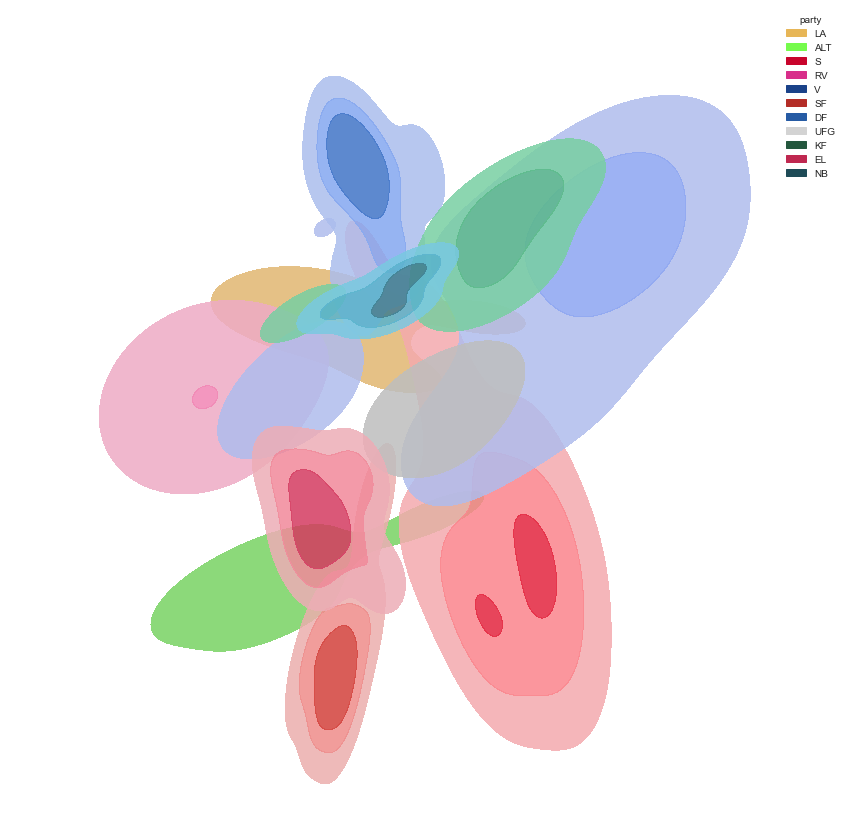

In [204]:
fig, ax = plt.subplots(figsize = (15,15))

sns.kdeplot(
    data = plot_docs,
    x = 'x',
    y = 'y',
    hue = 'party',
    palette = colormap,
    fill = True,
    thresh=0.1,
    ax = ax,
    alpha = .85,
    levels = 4,
    warn_singular = False
)

plt.axis('off')
plt.show()

In [11]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
